# ODEProblem. SIR epidemic model

Model ten dzieli rozpatrywaną populację na trzy stany:
- S (*susceptible*) - osoby, które jeszcze nie zostały zainfekowane, nie mają odporności, są więc podatne na zarażenie
- I (*infected*) - osoby obecnie zainfekowane ("chore") oraz zaraźliwe dla sąsiadów w stanie S
- R (*removed*) - niebrane pod uwagę w dalszym procesie z powodu uzyskania stałej odporności lub z powodu śmierci

Liczba osób w danym stanie opisywana jest w funkcji czasu, odpowiednio *I*, *S* albo *R*. Jednocześnie w danym czasie *t* suma wartości tych trzech funkcji w tym punkcie czasu wynosi *N* (liczebność rozpatrywanej populacji). Model SIR bazuje na następujących równaniach różniczkowych, opisujących tempo przyrostu liczebności poszczególnych grup:

<img src="./SIR_equations.png" />

gdzie:
- $\beta$ - współczynnik przenoszenia choroby: opisuje prawodpodobieństwo transmisji choroby z osoby z grupy *I* na osobę z grupy *R*
- $\gamma$ - współczynnik powrotu do zdrowia: opisuje tempo przejścia osób z grupy *I* do grupy *R*. Jest odwrotnie proporcjonalny do czasu potrzebnego do wyzdrowienia z choroby, wyrażonego w dniach, *n*

#### Współczynnik reprodukcji ####
Stanowi ważny parametr opisu dynamiki epidemii. Określa on średnią liczbę osób zakażonych przez jedną zainfekowaną osobę.
$$R_{0}=\frac{\beta}{\gamma}$$

Osoby, które przebyły chorobę COVID-19, wykształcają odporność trwającą przez co najmniej 5-7 miesięcy. Stanowi to na tyle długi okres czasu, że tzw. "ozdrowieńców" zakwalifikować można do grupy R, co umożliwia zastosowanie modelu SIR w badaniu przebiegu epidemii SARS-COV-2.

## 1.A DifferentialEquations Julia Package, Fourth-Order Runge-Kutta Method

#### Wykresy zmian liczby osób w poszczególnych stanach

In [376]:
 using DifferentialEquations
# using Plotly
 using Plots
# plotly()
# Plots.PlotlyBackend()
# using PlotlyBase
# using PyPlot

- **Obliczanie pochodnych w punktach czasu**

In [377]:
function parameterized_derivative!(du, u, p, t)
    S, I, R = u
    beta, gamma, N = p
    du[1] = -beta * S * I / N
    du[2] = beta * S * I / N - gamma * I
    du[3] = gamma * I
end

parameterized_derivative! (generic function with 1 method)

- **Rozwiązywanie układu równań różniczkowych dla danych parametrów modelu SIR**

In [378]:
function SIR_computations(parameters, variables, days)
    beta = parameters[1]
    gamma = parameters[2]
    N = parameters[3]
    
    I0 = variables[1]
    R0 = variables[2]
    S0 = variables[3]
    
    # Define differential equation problem
    u0 = [S0; I0; R0]
    tspan = (0.0, days)
    params = [ beta, gamma, N]
    prob = ODEProblem(parameterized_derivative!, u0, tspan, params);
    alg = RK4()

    # Solve system of differential equations
    sol = solve(prob, alg);
    return sol
end

SIR_computations (generic function with 1 method)

#### Wykres dla $\beta$ = 0.15, $\gamma$ = 1/21

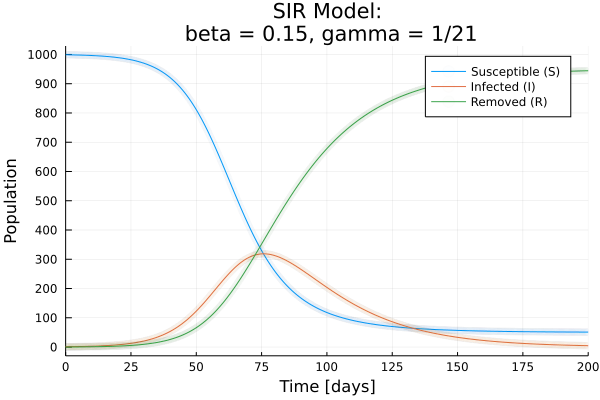

In [4]:
# Define model parameters
N = 1000.0
beta = 0.15
gamma = 1.0/21.0

# Define population
I0 = 1;
R0 = 0;
S0 = N - I0 - R0;

parameters = (beta, gamma, N)
variables = (I0, R0, S0)
days = 200.0

# Perform computations
result = SIR_computations(parameters, variables, days)

# Plot results
plot1 = Plots.plot(result, vars=[(0,1), (0,2), (0,3)], title="SIR Model:\n beta = 0.15, gamma = 1/21", 
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:25:200, yticks = 0:100:1000)

#### Wykres dla $\beta$ = 0.15, $\gamma$ = 1/14

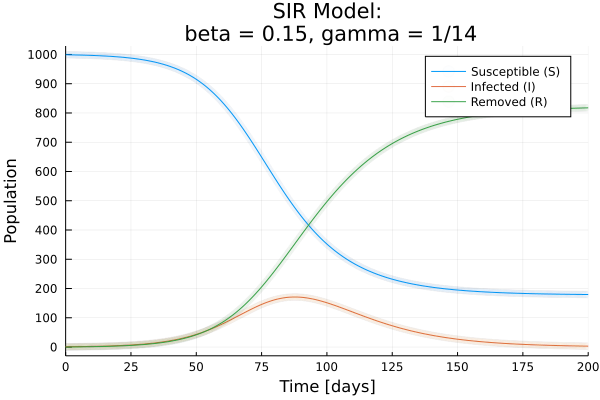

In [504]:
# Define model parameters
N = 1000.0
beta = 0.15
gamma = 1.0/14.0

# Define population
I0 = 1;
R0 = 0;
S0 = N - I0 - R0;

parameters = (beta, gamma, N)
variables = (I0, R0, S0)
days = 200.0

# Perform computations
result = SIR_computations(parameters, variables, days);

# Plot results
plot2 = Plots.plot(result, vars=[(0,1), (0,2), (0,3)], title="SIR Model:\n beta = 0.15, gamma = 1/14", 
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:25:200, yticks = 0:100:1000)

### Porównanie wykresów dla różnego czasu zdrowienia *n = 1/$\gamma$*

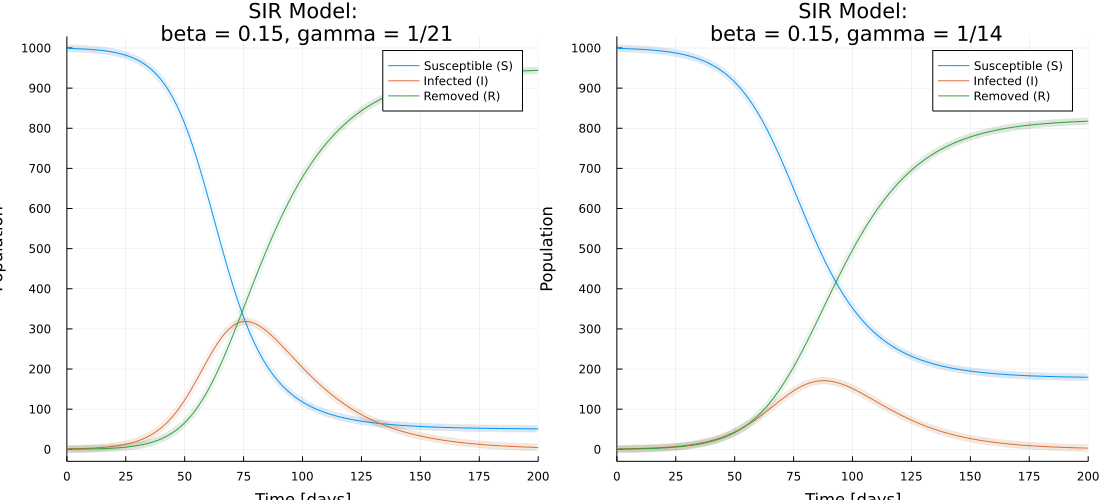

In [6]:
Plots.plot(plot1, plot2, layout=(1,2), size=(1100,500))

Zestawienie powyższych wykresów ilustruje zależność dynamiki przebiegu epidemii od czasu zdrowienia. Przyglądając się punktowi tzw. odporności zbiorowej, przyjmowanej jako R=70%, widać, że jest jest ona osiągana szybiej, gdy czas zdrowienia jest dłuższy (21 dni w porównaniu do 14 dni). Dzieje się tak ponieważ osobniki zakażone mają szansę zarażać dłużej, zanim wyzdrowieją, zatem fala zakażeń ma bardziej dynamiczny przebieg, większa liczba osób szybciej przechoruje, w konsekwencji czego odporność zbiorowa zostanie uzyskana szybciej.

## 1.B Fourth-Order Runge-Kutta Method Implementation

In [590]:
function Runge_Kutta(init_conditions, parameters, functions)
    # Initial conditions
    S0 = init_conditions[1]
    I0 = init_conditions[2]
    R0 = init_conditions[3]
    
    # Parameters (beta, gamma, N, days, h)
    beta = parameters[1]
    gamma = parameters[2]
    N = parameters[3]
    days = parameters[4]
    h = parameters[5]
    
    # Unpack the ODE functions
    dS = functions[1]
    dI = functions[2]
    dR = functions[3]
    
    # Initialise empty result arrs
    S_res = Any[]
    I_res = Any[]
    R_res = Any[]

    # Fill result arrs with initial conditions
    push!(S_res, S0)
    push!(I_res, I0)
    push!(R_res, R0)
    
    # Perform iterations
    for i in 1:days
        k1 = dS(S_res[i], I_res[i], R_res[i], N, beta, gamma)
        l1 = dI(S_res[i], I_res[i], R_res[i], N, beta, gamma)
        m1 = dR(S_res[i], I_res[i], R_res[i], N, beta, gamma)

        k2 = dS(S_res[i] + k1*h/2, I_res[i] + l1*h/2, R_res[i] + m1*h/2, N, beta, gamma)
        l2 = dI(S_res[i] + k1*h/2, I_res[i] + l1*h/2, R_res[i] + m1*h/2, N, beta, gamma)
        m2 = dR(S_res[i] + k1*h/2, I_res[i] + l1*h/2, R_res[i] + m1*h/2, N, beta, gamma)

        k3 = dS(S_res[i] + k2*h/2, I_res[i] + l2*h/2, R_res[i] + m2*h/2, N, beta, gamma)
        l3 = dI(S_res[i] + k2*h/2, I_res[i] + l2*h/2, R_res[i] + m2*h/2, N, beta, gamma)
        m3 = dR(S_res[i] + k2*h/2, I_res[i] + l2*h/2, R_res[i] + m2*h/2, N, beta, gamma)

        k4 = dS(S_res[i] + k3*h, I_res[i] + l3*h, R_res[i] + m3*h, N, beta, gamma)
        l4 = dI(S_res[i] + k3*h, I_res[i] + l3*h, R_res[i] + m3*h, N, beta, gamma)
        m4 = dR(S_res[i] + k3*h, I_res[i] + l3*h, R_res[i] + m3*h, N, beta, gamma)

        S_next = S_res[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        I_next = I_res[i] + (h/6)*(l1 + 2*l2 + 2*l3 + l4)
        R_next = R_res[i] + (h/6)*(m1 + 2*m2 + 2*m3 + m4)

        push!(S_res, S_next)
        push!(I_res, I_next)
        push!(R_res, R_next)
    end
    
    return S_res, I_res, R_res
end

Runge_Kutta (generic function with 1 method)

## 2. Responsive Plots

In [326]:
# using IJulia
# using Conda
# using Interact
# using WebIO
# WebIO.install_jupyter_labextension()
# notebook(dir = Interact.notebookdir)
# WebIO.install_jupyter_labextension(condajl=true)
# using WebIO
# WebIO.install_jupyter_nbextension()
#using Blink

In [199]:
using Mux
#WebIO.webio_serve(page("/", req -> ui), rand(8000:9000))
WebIO.webio_serve(page("/", req -> tot), 8007)

Task (runnable) @0x0000000088d5ad60

Error handling websocket connection:
TaskFailedException
Stacktrace:
  [1] wait
    @ .\task.jl:317 [inlined]
  [2] create_socket(req::Dict{Any, Any})
    @ WebIO ~\.julia\packages\WebIO\Fy9h1\src\providers\mux.jl:47
  [3] (::Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)})(f::Function, x::Dict{Any, Any})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:17
  [4] (::Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}})(x::Dict{Any, Any})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10
  [5] splitquery(app::Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}}, req::Dict{Any, Any})
    @ Mux ~\.julia\packag

In [591]:
using Interact
using Plots
using Blink
using InteractBulma

# Define the ODE functions
dS(S, I, R, N, beta, gamma) = -beta * S * I / N
dI(S, I, R, N, beta, gamma) = beta * S * I / N - gamma * I
dR(S, I, R, N, beta, gamma) = gamma * I

funcs = (dS, dI, dR)

# Visualisation
run_toggle_1 = toggle(label = "run") |> onchange
reset_toggle_1 = toggle(label = "reset") |> onchange
speed_toggle_1 = togglebuttons(OrderedDict(zip(["x1.0", "x2.0", "x5.0", "x10.0"], [1, 2, 5, 10])))

run_toggle_2 = toggle(label = "run") |> onchange
reset_toggle_2 = toggle(label = "reset") |> onchange
speed_toggle_2 = togglebuttons(OrderedDict(zip(["x1.0", "x2.0", "x5.0", "x10.0"], [1, 2, 5, 10])))

I0_box_1 = textbox("Initial condition: I0") |> onchange
R0_box_1 = textbox("Initial condition: R0") |> onchange

I0_box_2 = textbox("Initial condition: I0") |> onchange
R0_box_2 = textbox("Initial condition: R0") |> onchange

global timer_1 = Observable(0)
global speed_1 = 1

global timer_2 = Observable(0)
global speed_2 = 1

global initial_I0_1 = 1
global initial_R0_1 = 0

global initial_I0_2 = 1
global initial_R0_2 = 0

function switch_timer_1(switch)
    if switch
    global time_fun_A1 = @async while true
            sleep(1)
            timer_1[] += 1
        end
    return
    else
        @async Base.throwto(time_fun_A1, InterruptException())
    end
    return
end

function reset_timer_1(res)
    if !res
    global time_fun_A2 = @async while true
        sleep(1)
        end
    return
    else
        timer_1[] = 0
        @async Base.throwto(time_fun_A2, InterruptException())
    end
    return
end

function modify_speed_1(sp)
    global speed_1 = sp
    return
end

function switch_timer_2(switch)
    if switch
    global time_fun_B1 = @async while true
            sleep(1)
            timer_2[] += 1
        end
    return
    else
        @async Base.throwto(time_fun_B1, InterruptException())
    end
    return
end

function reset_timer_2(res)
    if !res
    global time_fun_B2 = @async while true
        sleep(1)
        end
    return
    else
        timer_2[] = 0
        @async Base.throwto(time_fun_B2, InterruptException())
    end
    return
end

function modify_speed_2(sp)
    global speed_2 = sp
    return
end

function modify_I0_1(change)
    global initial_I0_1 = parse(Int64, change)
    return
end

function modify_R0_1(change)
    global initial_R0_1 = parse(Int64,change)
    return
end

function modify_I0_2(change)
    global initial_I0_2 = parse(Int64, change)
    return
end

function modify_R0_2(change)
    global initial_R0_2 = parse(Int64,change)
    return
end

Ns_1 = slider(1:1000; label = "N")
Betas_1 = slider(0:0.01:1.0; label = "Beta")
Gammas_1 = slider(0:0.01:1.0; label = "Gamma")
Duration_1 = slider(0:10:1000; label = "Duration [Days]")
H_1 = slider(0:0.1:2; label = "RK4 step")


ui1 = @manipulate for N in Ns_1, Beta in Betas_1, Gamma in Gammas_1, Days in Duration_1, h in H_1, t=timer_1
    up_days = t*10*speed_1 % Days
    parameters = (Beta, Gamma, N, up_days, h)
    I0 = initial_I0_1
    R0 = initial_R0_1
    S0 = N - I0 - R0
    init_conds = (S0, I0, R0)
    output = Runge_Kutta(init_conds, parameters, funcs);
    plt = plot([output[1] output[2] output[3]], vars=[(0,1), (0,2), (0,3)], title=string("SIR Model:\n", "beta = ", round(Beta, digits=2), ", ", "gamma = ", round(Gamma, digits=2)),
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:(Days/10):Days, yticks = 0:(N/10):N)
    wdg = Widget(["N" => N, "Beta" => Beta, "Gamma" => Gamma])
    @layout! wdg pad(1em, pad(1em, hbox(plt, vbox(:N, :Beta, :Gamma, :t))))
end

Ns_2 = slider(1:1000; label = "N")
Betas_2 = slider(0:0.01:1.0; label = "Beta")
Gammas_2 = slider(0:0.01:1.0; label = "Gamma")
Duration_2 = slider(0:10:1000; label = "Duration [Days]")
H_2 = slider(0:0.1:2; label = "RK4 step")

ui2 = @manipulate for N in Ns_2, Beta in Betas_2, Gamma in Gammas_2, Days in Duration_2, h in H_2, t=timer_2#, I0=initial_I0_1, R0=initial_R0_1
    up_days = t*10*speed_2 % Days
    parameters = (Beta, Gamma, N, up_days, h)
    I0 = initial_I0_2
    R0 = initial_R0_2
    S0 = N - I0 - R0
    init_conds = (S0, I0, R0)
    output = Runge_Kutta(init_conds, parameters, funcs);
    plt = plot([output[1] output[2] output[3]], vars=[(0,1), (0,2), (0,3)], title=string("SIR Model:\n", "beta = ", round(Beta, digits=2), ", ", "gamma = ", round(Gamma, digits=2)), 
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:(Days/10):Days, yticks = 0:(N/10):N)
    wdg = Widget(["N" => N, "Beta" => Beta, "Gamma" => Gamma])
    @layout! wdg pad(1em, hbox(plt, pad(1em, vbox(:N, :Beta, :Gamma, :t)))) ## custom layout: by default things are stacked vertically
end

on(switch_timer_1, run_toggle_1)
on(reset_timer_1, reset_toggle_1)
on(modify_speed_1, speed_toggle_1)

on(switch_timer_2, run_toggle_2)
on(reset_timer_2, reset_toggle_2)
on(modify_speed_2, speed_toggle_2)

on(modify_I0_1, I0_box_1)
on(modify_R0_1, R0_box_1)

on(modify_I0_2, I0_box_2)
on(modify_R0_2, R0_box_2)

Ns_3 = slider(1:1000; label = "N")
Betas_3 = slider(0:0.01:1.0; label = "Beta")
Gammas_3 = slider(0:0.01:1.0; label = "Gamma")
Duration_3 = slider(0:10:1000; label = "Duration [Days]")
H_3 = slider(0:0.1:2; label = "RK4 step")

ui3 = @manipulate for N in Ns_3, Beta in Betas_3, Gamma in Gammas_3, Days in Duration_3, h in H_3, I0=I0, R0=R0
    parameters = (Beta, Gamma, N)
    params = (Beta, Gamma, N, Days, h)
    
    S0 = N - I0 - R0
    init_conds = (I0, R0, S0)
    init_condits = (S0, I0, R0)
    
    output_3 = SIR_computations(parameters, init_conds, Days);
    output_4 = Runge_Kutta(init_condits, params, funcs);
    
    plt3 = plot(output_3, vars=[(0,1), (0,2), (0,3)], title=string("SIR Model: ODEProblem DifferentialEquations\n", "beta = ", round(Beta, digits=2), ", ", "gamma = ", round(Gamma, digits=2)), 
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:(Days/10):Days, yticks = 0:(N/10):N)
    
    plt4 = plot([output_4[1] output_4[2] output_4[3]], vars=[(0,1), (0,2), (0,3)], title=string("SIR Model: ODEProblem homemade\n", "beta = ", round(Beta, digits=2), ", ", "gamma = ", round(Gamma, digits=2)), 
    xaxis="Time [days]", yaxis="Population", marker=0.01, label=["Susceptible (S)" "Infected (I)" "Removed (R)"],
    xticks = 0:(Days/10):Days, yticks = 0:(N/10):N)
   
    wdg = Widget(["N" => N, "Beta" => Beta, "Gamma" => Gamma, "Duration" => Days])
    @layout! wdg pad(1em, hbox(plt3, pad(1em, vbox(:N, :Beta, :Gamma, :Duration)), plt4))
end

o=Observable(ui3)
ui3

tot = vbox(
    Interact.hline(color="darkblue"),
    pad(2em, hbox("1. Fourth Order Runge-Kutta ODE Method")),
    Interact.hline(color="darkblue"),
    pad(1em, hbox(
            hbox(
                pad(1em, run_toggle_1), pad(1em, reset_toggle_1), 
                pad(1em, I0_box_1), pad(1em, R0_box_1)
                ),
            hbox(
                pad(1em, run_toggle_2), pad(1em, reset_toggle_2), 
                pad(1em, I0_box_2), pad(1em, R0_box_2)
                )
        )),
    pad(1em, hbox(pad(1em, speed_toggle_1), pad(1em, speed_toggle_2))),
    pad(1em, hbox(pad(1em, ui1), pad(1em, ui2))),
    Interact.hline(color="darkblue"),
    pad(2em, hbox("2. Porównanie metody Rungego-Kutty z pakietu DifferentialEquations z metodą własnoręczną")),
    Interact.hline(color="darkblue"),
    pad(1em, hbox(pad(1em, ui3)))
    )

window = Window()
body!(window, tot)

Page(229, WebSocket(server, CONNECTED), Dict{String, Any}("webio" => Blink.AtomShell.var"#22#23"{Blink.AtomShell.WebIOBlinkComm}(Blink.AtomShell.WebIOBlinkComm(Window(235, Electron(Process(`'C:\Users\basia\.julia\packages\Blink\mwJC9\deps\atom\electron.exe' 'C:\Users\basia\.julia\packages\Blink\mwJC9\src\AtomShell\main.js' port 5353`, ProcessRunning), Sockets.TCPSocket(Base.Libc.WindowsRawSocket(0x00000000000005cc) active, 0 bytes waiting), Dict{String, Any}("callback" => Blink.var"#1#2"())), Page(#= circular reference @-5 =#), Task (done) @0x0000000088b8c4c0))), "callback" => Blink.var"#1#2"()), Distributed.Future(1, 1, 235, Some(true)))

Error handling websocket connection:
TaskFailedException
Stacktrace:
  [1] wait
    @ .\task.jl:317 [inlined]
  [2] create_socket(req::Dict{Any, Any})
    @ WebIO ~\.julia\packages\WebIO\Fy9h1\src\providers\mux.jl:47
  [3] (::Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)})(f::Function, x::Dict{Any, Any})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:17
  [4] (::Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}})(x::Dict{Any, Any})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10
  [5] splitquery(app::Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}}, req::Dict{Any, Any})
    @ Mux ~\.julia\packag

    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10 [inlined]
  [7] wcatch(app::Mux.var"#1#2"{typeof(Mux.splitquery), Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}}}, req::Dict{Any, Any})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\websockets_integration.jl:12
  [8] #1
    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10 [inlined]
  [9] todict
    @ ~\.julia\packages\Mux\3h8RY\src\basics.jl:25 [inlined]
 [10] #3 (repeats 2 times)
    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:14 [inlined]
 [11] (::Mux.var"#1#2"{Mux.var"#3#4"{Mux.var"#3#4"{typeof(Mux.todict), typeof(Mux.wcatch)}, typeof(Mux.splitquery)}, Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}

    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10 [inlined]
  [9] todict
    @ ~\.julia\packages\Mux\3h8RY\src\basics.jl:25 [inlined]
 [10] #3 (repeats 2 times)
    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:14 [inlined]
 [11] (::Mux.var"#1#2"{Mux.var"#3#4"{Mux.var"#3#4"{typeof(Mux.todict), typeof(Mux.wcatch)}, typeof(Mux.splitquery)}, Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}}})(x::Tuple{HTTP.Messages.Request, WebSockets.WebSocket{Sockets.TCPSocket}})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10
 [12] (::Mux.var"#9#10"{Mux.App})(req::HTTP.Messages.Request, client::WebSockets.WebSocket{Sockets.TCPSocket})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\server.jl:49
 [13] upgrade(f::Mux.var"#9#10"{Mux.App}, stream::HTTP.Streams.Stream{HTTP.Messages.Request, HTTP.ConnectionPool.Transaction{Sockets.TCPSocket}})


  [9] todict
    @ ~\.julia\packages\Mux\3h8RY\src\basics.jl:25 [inlined]
 [10] #3 (repeats 2 times)
    @ ~\.julia\packages\Mux\3h8RY\src\Mux.jl:14 [inlined]
 [11] (::Mux.var"#1#2"{Mux.var"#3#4"{Mux.var"#3#4"{typeof(Mux.todict), typeof(Mux.wcatch)}, typeof(Mux.splitquery)}, Mux.var"#1#2"{Mux.var"#5#6"{Mux.var"#31#32"{Vector{SubString{String}}}, typeof(WebIO.create_socket)}, Mux.var"#1#2"{typeof(Mux.wclose), Mux.var"#1#2"{Mux.var"#21#22"{Mux.var"#25#26"{Symbol, Int64}}, Mux.var"#23#24"{String}}}}})(x::Tuple{HTTP.Messages.Request, WebSockets.WebSocket{Sockets.TCPSocket}})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\Mux.jl:10
 [12] (::Mux.var"#9#10"{Mux.App})(req::HTTP.Messages.Request, client::WebSockets.WebSocket{Sockets.TCPSocket})
    @ Mux ~\.julia\packages\Mux\3h8RY\src\server.jl:49
 [13] upgrade(f::Mux.var"#9#10"{Mux.App}, stream::HTTP.Streams.Stream{HTTP.Messages.Request, HTTP.ConnectionPool.Transaction{Sockets.TCPSocket}})
    @ WebSockets ~\.julia\packages\WebSockets\QcswW\src\HT

## Zadanie z równań różniczkowych

Interaktywne demonstracje

Należy wybrać jeden temat z pliku Mownit__ODE.pdf

Rozwiązaniem jest program pokazujący w interaktywny sposób rozwiązanie danego problemu obliczeniowego. Program powinien mieć graficzny interfejs użytkownika oraz umozliwiać dynamiczną interakcję poprzez zmianę parametrów. Język programowania oraz środowisko: dowolne.
Proponowane rozwiązania:

- Dash: https://dash.plotly.com/
- Pakiet Shiny w R: https://shiny.rstudio.com
- Julia + AngularJS + Plotly, przykład: https://github.com/JuliaDiffEq/DiffEqOnline
- Julia interact, przykład: https://github.com/JuliaGizmos/Interact.jl
- C + GSL + JavaFX
...
Jako rozwiązanie należy załączyć plik Jupyter notebook lub HTML zawierający np. link do nagranego filmiku z demonstracją działania programu.

Zadanie 2-tygodniowe